## Fitting Curly's sphere in water sims
in order to check consistency with my simulations

In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [18]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [19]:
pixel_num = 300
boundary_pixel_coords_in_nm = [
    -750,
    750,
    -750,
    750,
    ]
pixel_size = (
    boundary_pixel_coords_in_nm[1] - boundary_pixel_coords_in_nm[0]
    )/(pixel_num)

exp_obs_pts = diffi.observation_points(
    boundary_pixel_coords_in_nm[0]*cm_per_nm, 
    boundary_pixel_coords_in_nm[1]*cm_per_nm, 
    boundary_pixel_coords_in_nm[2]*cm_per_nm, 
    boundary_pixel_coords_in_nm[3]*cm_per_nm, 
    300,) ## cm_per_m

# img_extent = [
#     boundary_pixel_coords_in_nm[0] - .5*pixel_size,
#     boundary_pixel_coords_in_nm[1] + .5*pixel_size,
#     boundary_pixel_coords_in_nm[2] - .5*pixel_size,
#     boundary_pixel_coords_in_nm[3] + .5*pixel_size,
# ]

def img_extent(field_dict):
    
    ## Define extent in nanometers.
    extent_nm = np.array([
        field_dict['x_image'].min(),
        field_dict['x_image'].max(),
        field_dict['y_image'].min(),
        field_dict['y_image'].max(),])*(1e9) #nm/m

    return extent_nm

In [20]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'simple_sphere_sims_011720',
    'reanysimulationyouwantmetodo'
    )

In [21]:
curly_images = {}

def file_name_base(numstr): 
    return f"AuNS_D40_{numstr:d}_X_01_16_20_ff_at558"

In [22]:
for i in range(21):
    curly_images[i+1] = sio.loadmat(
        os.path.join(path_to_data, file_name_base(i+1)+".mat"))

In [23]:
curly_images.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

Let's check out one of these images

In [24]:
curly_images[1].keys()

dict_keys(['__header__', '__version__', '__globals__', 'E2_image_xy', 'x_dip', 'x_image', 'y_dip', 'y_image', 'z_dip'])

In [25]:
curly_images[1]['E2_image_xy'].shape

(300, 300)

In [26]:
array_of_curly_imgs = np.empty((21, 300**2))
for i in range(21):
    array_of_curly_imgs[i] = curly_images[i+1]['E2_image_xy'].ravel()

## Lets look at some plots

In [32]:
curly_images[4]['x_dip']

array([[3.125e-08]])

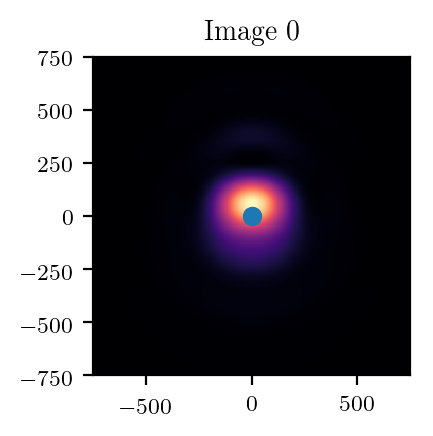

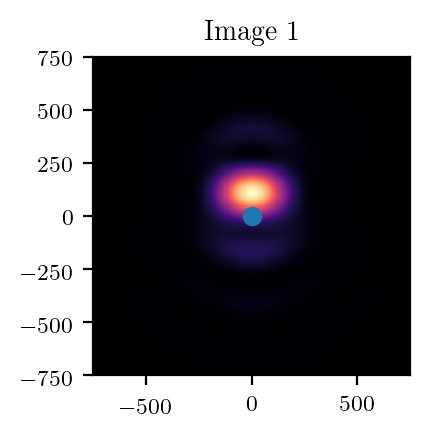

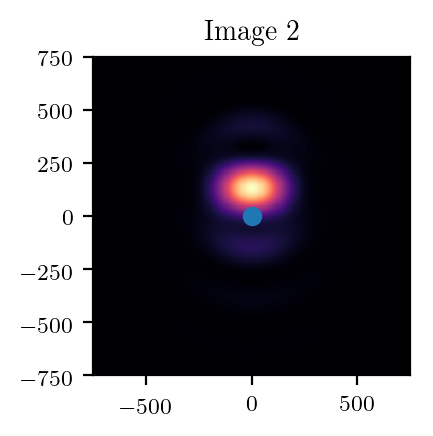

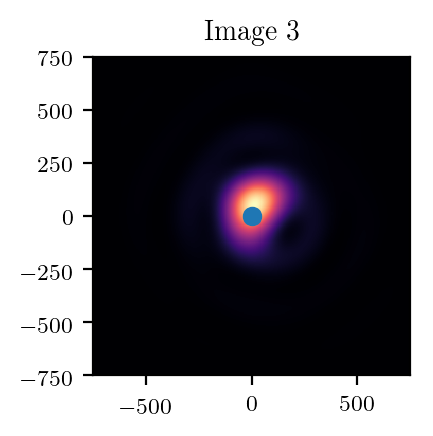

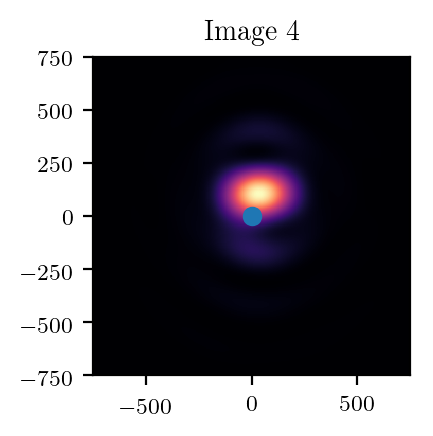

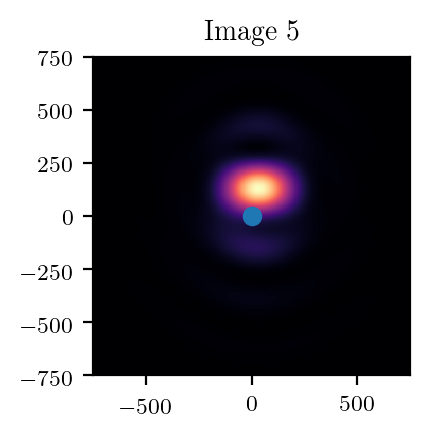

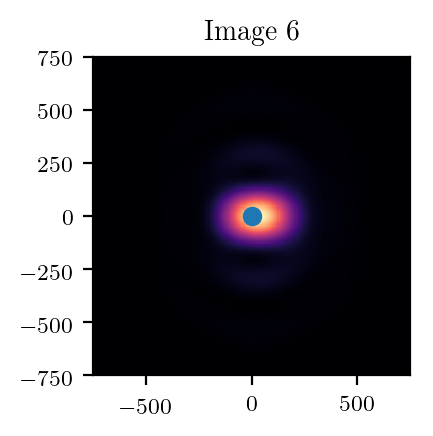

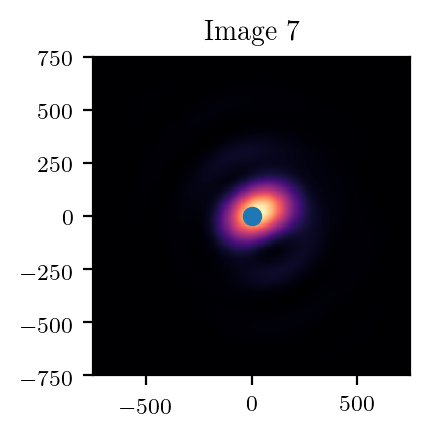

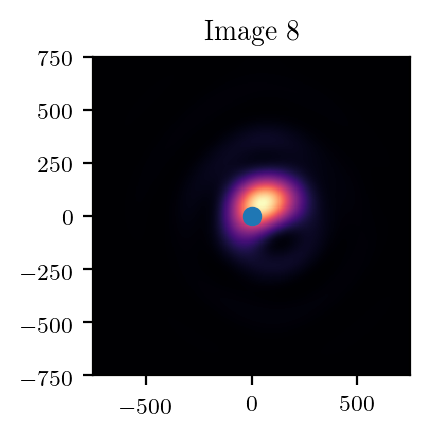

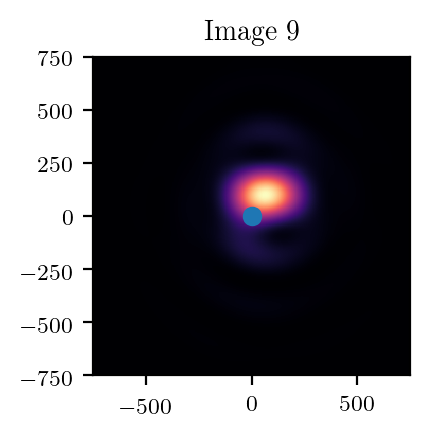

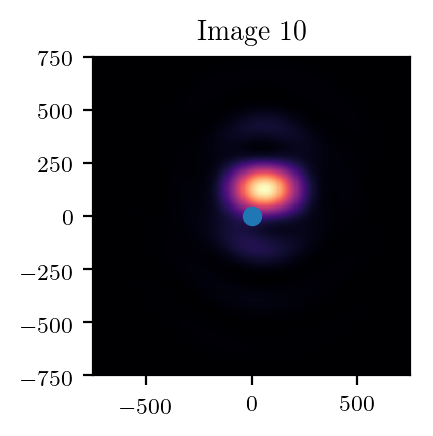

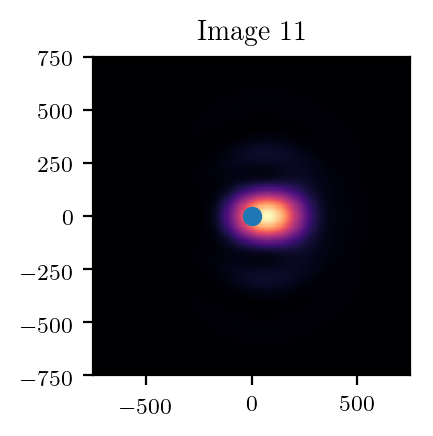

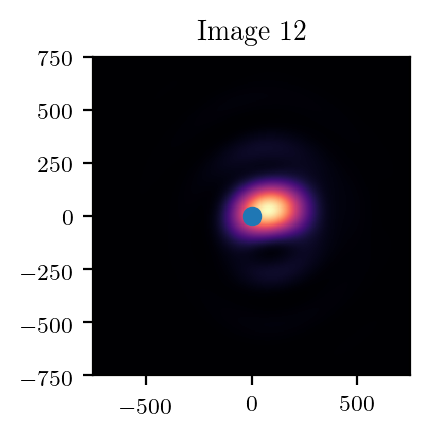

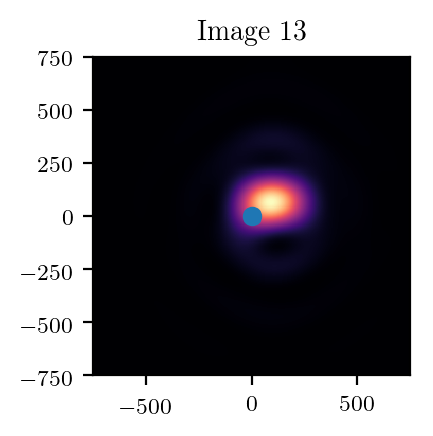

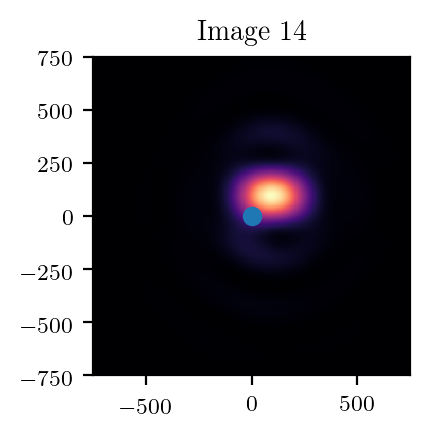

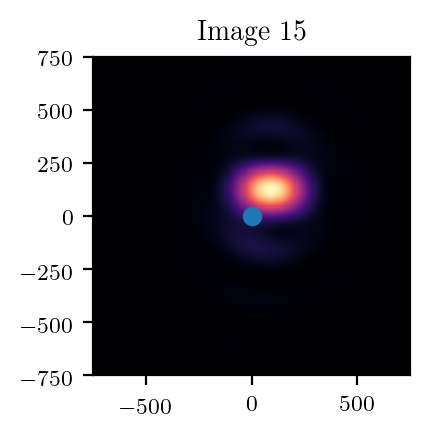

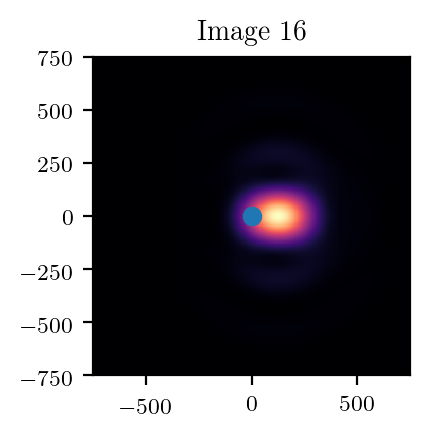

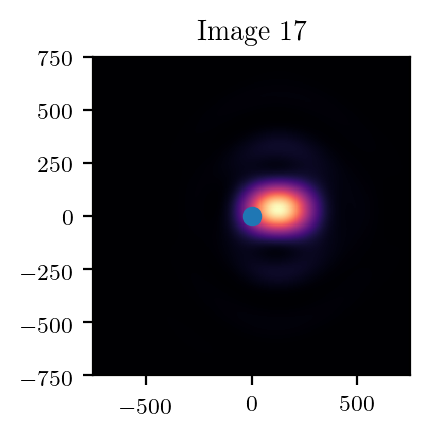

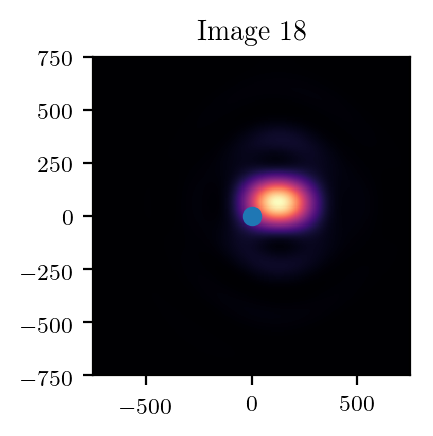

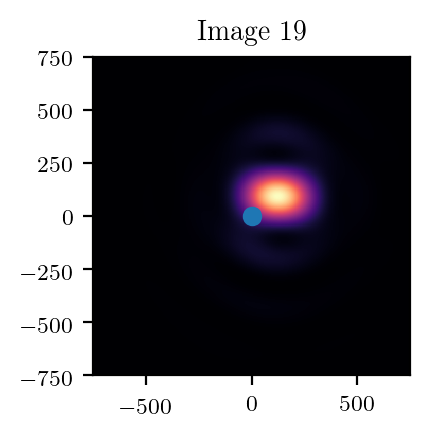

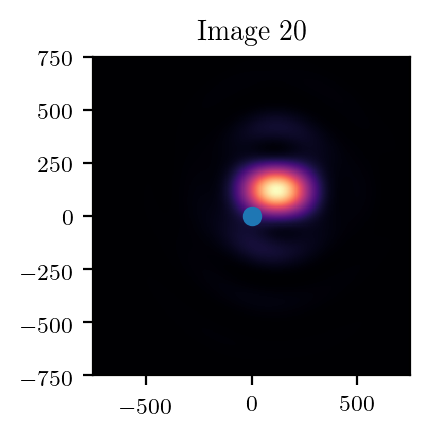

In [33]:
for i in range(21):
    plt.figure()
    plt.imshow(
        curly_images[1+i]['E2_image_xy'], 
        origin='lower',
        extent=img_extent(curly_images[1+i])
        )
    ## Plot location
    plt.scatter(
        curly_images[1+i]['x_dip'], curly_images[1+i]['y_dip'])
    plt.title(f"Image {i:d}")

In [35]:
## from fit to near field spec with high energy gaussian
fit_parameters = np.array([
    [ 6.06943589e+01,  1.62580947e-02,  1.56766118e+00],
    [ 8.00896018e+01, -7.45781942e-02,  1.56998340e+00],
    [ 1.04057440e+02,  1.27348932e-04,  1.57077921e+00],
    [ 6.72896594e+01,  3.36932199e+01,  1.46119448e+00],
    [ 8.34614210e+01,  2.72917121e+01,  1.53573748e+00],
    [ 1.06677941e+02,  2.71923424e+01,  1.53596290e+00],
    [ 5.76228801e-02,  8.06195080e+01,  1.56838025e+00],
    [ 3.65462780e+01,  7.58721483e+01,  1.41170389e+00],
    [ 6.43684419e+01,  7.10479490e+01,  1.45339061e+00],
    [ 8.70525590e+01,  6.05900731e+01,  1.56168954e+00],
    [ 1.08998013e+02,  5.56256111e+01,  1.52525702e+00],
    [-6.74852073e-02,  1.02497271e+02,  1.56992256e+00],
    [ 3.06169952e+01,  1.01291275e+02,  1.50785005e+00],
    [ 5.95187644e+01,  9.74109030e+01,  1.50392641e+00],
    [ 8.51399185e+01,  8.94753461e+01,  1.52003615e+00],
    [ 1.08989464e+02,  8.36671615e+01,  1.50365983e+00],
    [ 5.86144128e-02,  1.24242023e+02,  1.57077491e+00],
    [ 2.86254874e+01,  1.23094503e+02,  1.53631556e+00],
    [ 5.63952821e+01,  1.19195078e+02,  1.51582326e+00],
    [ 8.24417049e+01,  1.13546794e+02,  1.49961888e+00],
    [ 1.08407791e+02,  1.10110887e+02,  1.49124987e+00]])

In [50]:
def image_from_params(
    params, 
    plas_loc,
    drive_hw,
    resolution=None,
    param_file=None
    ):
    """ 
        Args
        ----
        
        params = [
            d=[x, y, z], : mol location relative to plasmon
            phi, : mole angle
            ]
    
        """
    dx = params[0]
    dy = params[1]
    phi = params[2]
    
    if resolution is None:
        obs_pts = None
    else:
        obs_pts = diffi.observation_points(
            0, 48*20*m_per_nm, 0, 48*20*m_per_nm, resolution)
        
    cp_inst=fit.CoupledDipoles(
        obs_points=obs_pts, 
        drive_energy_eV=drive_hw,
        param_file=param_file,
        sphere_model='Mie'
    )

    ## Hack to fix bug in fit.
    cp_inst.drive_I = np.abs(cp_inst.drive_amp)**2.
    field_output = cp_inst.dipole_fields(
            np.array([[dx, dy, 0]]), 
            mol_angle=phi, 
            plas_angle=0, 
            )
    raveled_image = cp_inst.image_from_E(field_output[0]+field_output[1])
    
    return raveled_image

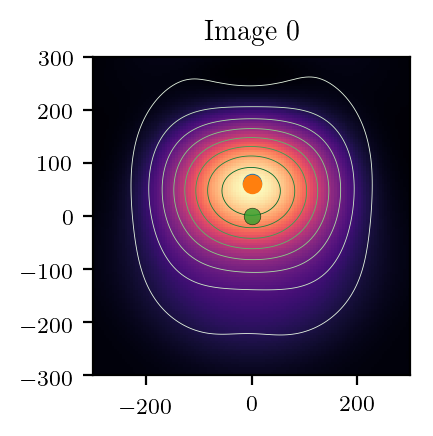

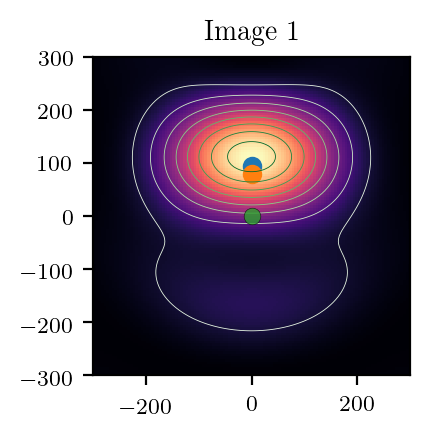

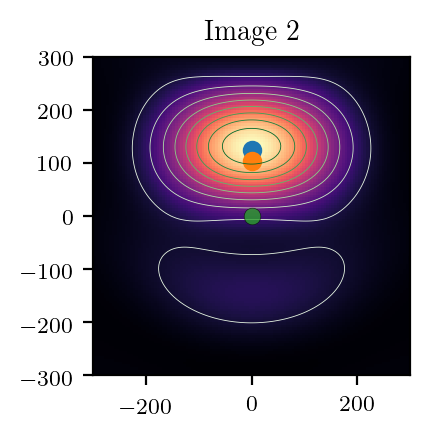

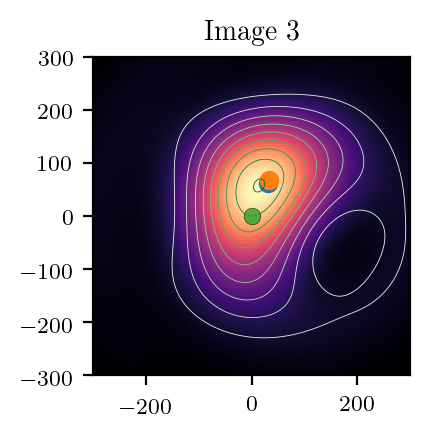

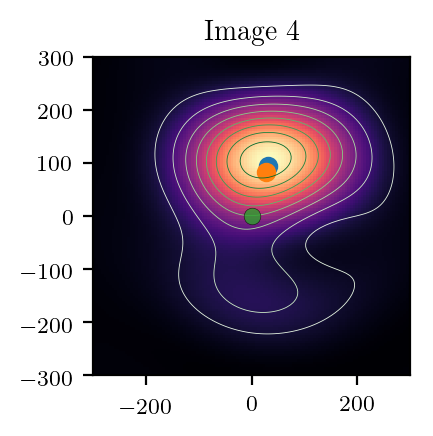

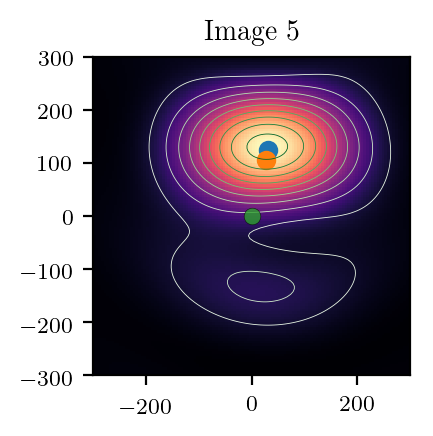

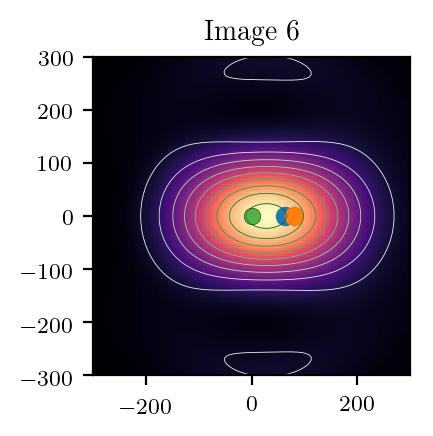

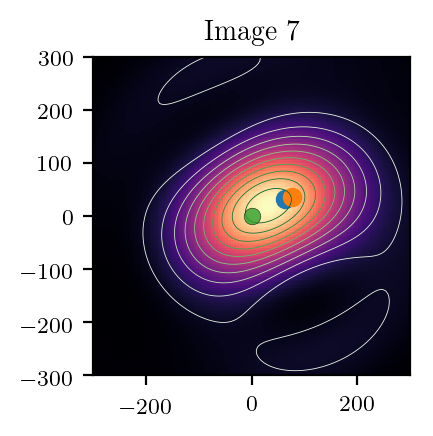

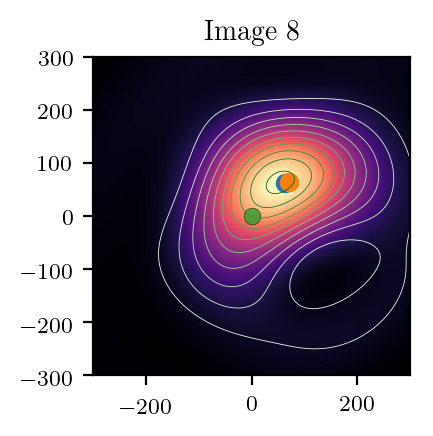

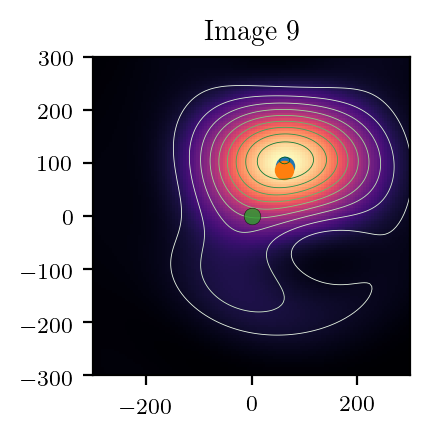

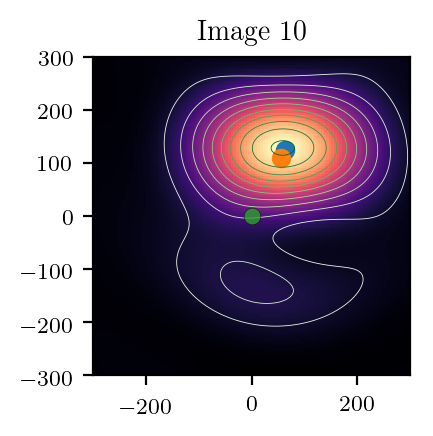

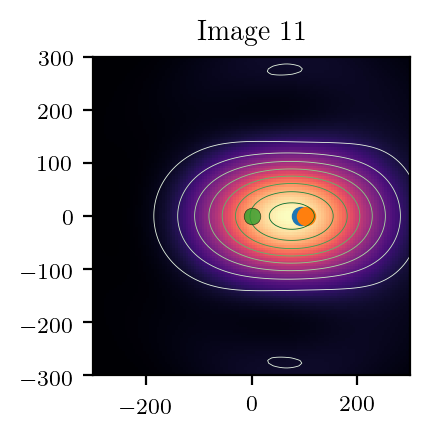

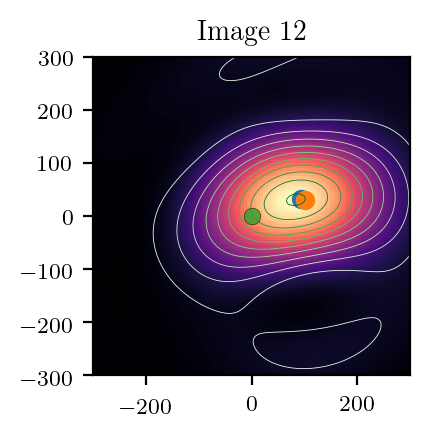

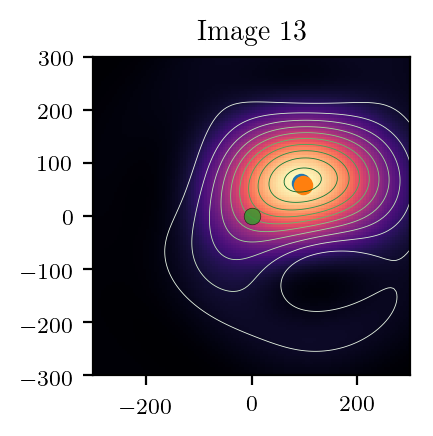

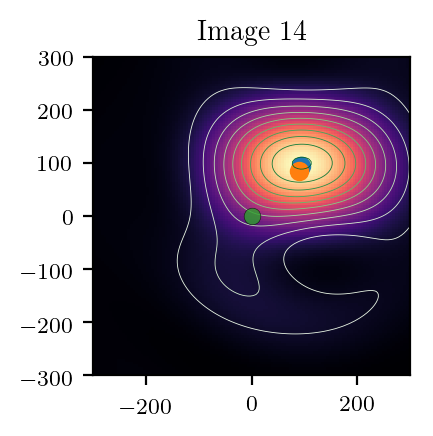

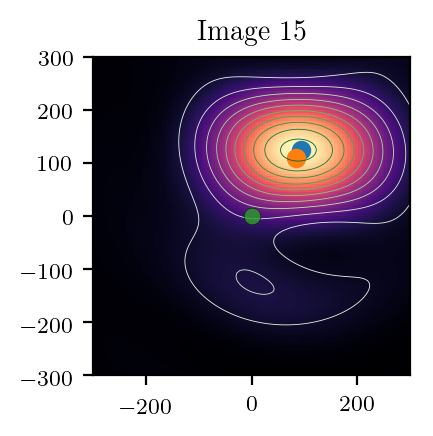

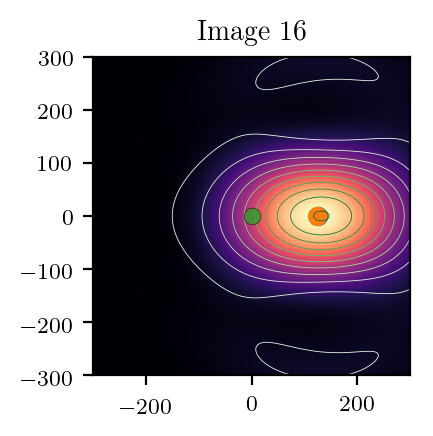

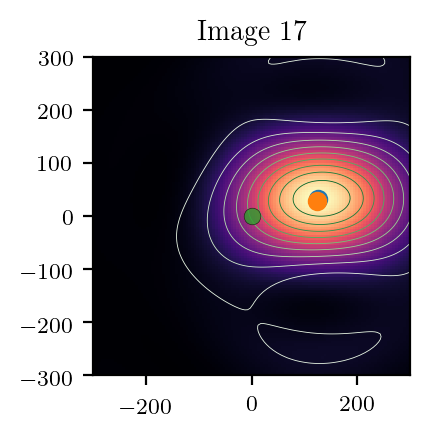

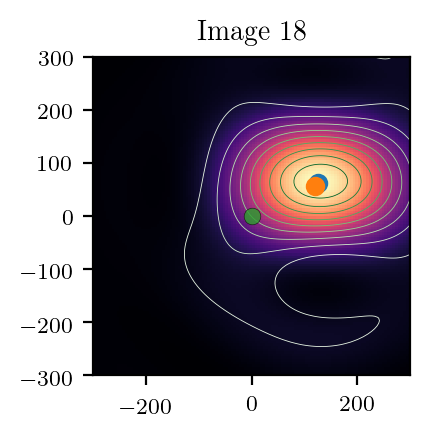

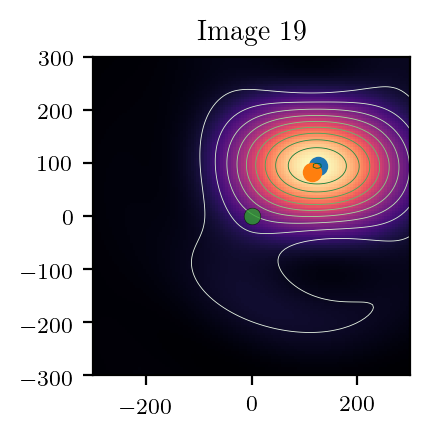

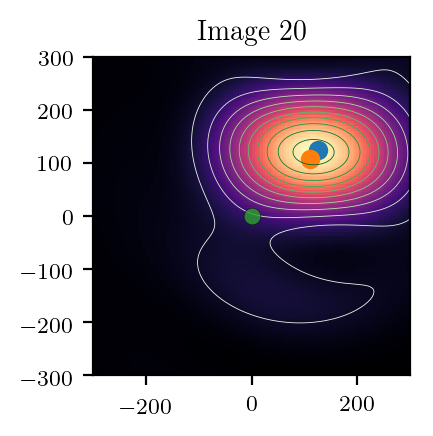

In [70]:
the_plas_loc = [0,0,0]
max_hw = 2.2185
for i in range(21):
    fig, ax = plt.subplots()
    ax.imshow(
        curly_images[1+i]['E2_image_xy'], 
        origin='lower',
        extent=img_extent(curly_images[1+i])
        )
    ## Plot location
    ax.scatter(
        curly_images[1+i]['x_dip']*1e9, curly_images[1+i]['y_dip']*1e9)
    ax.set_title(f"Image {i:d}")

    ax.contour(
        np.linspace(-750, 750 ,300),
        np.linspace(-750, 750 ,300),
        (image_from_params(
            fit_parameters[i], 
            the_plas_loc,
            drive_hw=max_hw,
            param_file='sphere_80nmJC_curlySim_wGau'
    #         resolution=201
            )).reshape(300,300),
        cmap='Greens',
        linewidths=0.3,
        levels=10,
    #     label='model img.'
        )
    # plot fit estiumated molecule location
    ax.scatter(*fit_parameters[i, 1::-1])
    
    ## Mark plasmon position
    ax.scatter(
        the_plas_loc[1], 
        the_plas_loc[0], 
        zorder=5,
        alpha=.8,
        edgecolor='k',
        linewidth=.2,
        label='Nanoparticle pos.'
        )
    ax.set_xlim([-300,300])
    ax.set_ylim([-300,300])